# TruthLens Data Cleaning and Exploration
The purpose of this notebook is to prepare the data, both the ISOT dataset and the custom scraped data, for the modelling process. 

## Phase 1: Real vs. Fake News Classification
The first stage leverages the ISOT dataset, which contains almost 45,000 long-form articles evenly distributed between two classes: real and fake news. The dataset is well-suited for binary classification due to its balance and scale. Using an existing dataset eliminates the need for custom data collection for this phase and accelerates development.

Phase 1 preprocessing includes tokenisation, stop-word removal, and text normalisation. These steps ensure consistency and reduce noise in the input data, enabling efficient model training.

The ISOT database has been downloaded from https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/ and the dataset description is available here: https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/02/ISOT_Fake_News_Dataset_ReadMe.pdf

In [12]:
#all imports
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
import time
import csv
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
import string
from string import punctuation
import swifter
from textacy import preprocessing
from wordcloud import WordCloud
from tqdm.notebook import tqdm
tqdm.pandas()

#settings
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hazel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\hazel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


### Load the dataset

In [13]:
ISOT_True = 'ISOT-True.csv'  
ISOT_Fake = 'ISOT-Fake.csv'  
#load each subset to a dataframe
true_df = pd.read_csv(ISOT_True)
fake_df = pd.read_csv(ISOT_Fake)
#add a label for each class - 0 for True and 1 for False
true_df['label'] = 0
fake_df['label'] = 1
#combine the dataframes
df = pd.concat([true_df, fake_df], ignore_index=True)
#shuffle the dataset
df = df.sample(frac=1, random_state=999).reset_index(drop=True)
#combine the title and text columns into a single column
df['content'] = df['title'] + " " + df['text']
#drop unnecessary columns
df = df[['content', 'label']] 
#basic checks
print("DataFrame Info:")
df.info()
print("\nClass overview:")
print(df['label'].value_counts())
#store
df.to_csv('ISOT.csv', index=False)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  44898 non-null  object
 1   label    44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB

Class overview:
1    23481
0    21417
Name: label, dtype: int64


### Replace censored words
I've noticed that the data contains a lot of censored words - for example "f*ck" instead of "fuck", so I am replacing those with the uncensored versions before continuing with preprocessing.

In [14]:
def find_censored_words(dataframe, column_name):
    """
    Finds censored words in the specified column of a DataFrame, where a censored word contains one or more * e.g. f*ck.

    Parameters:
    ----------
    dataframe : pd.DataFrame
        The DataFrame containing the text data.
    column_name : str
        The name of the column to search for censored words.

    Returns:
    -------
    list
        A set of unique censored words found in the specified column.
    """
    #Regex pattern for censored words - word boundary, 1 or more alphanumeric characters on each side, 1 or more asterix.
    pattern = r'\b\w+\*+\w+\b'
    # Combine all text in the specified column
    combined_text = ' '.join(dataframe[column_name].astype(str)).lower() 
    # Find all matches of the pattern
    censored_words = re.findall(pattern, combined_text)
    # Return unique matches
    return list(set(censored_words))

In [15]:
#Find censored words
start_time = time.time()
censored_words = find_censored_words(df, 'content')
print("Sample of censored words found:\n", ' '.join(random.sample(censored_words, 10)))
print("Find censored words: {:.4f} seconds".format(time.time() - start_time))

Sample of censored words found:
 n**gers horses**t 2017*hypocrite sh*tcanned batsh*t c*nts sh*ts q****s warning***i c*ckblocking
Find censored words: 10.2640 seconds


In [16]:
substitutions = {
    'f*ckton':'fuckton', 'bs':'bullshit', 'sh**tting':'shitting', 'sh*tter':'shitter', 'p****y':'pussy', 'f*ckballs':'fuckballs', 'ni**ers':'niggers', 'motherf***er':'motherfucker', 'ni***r':'nigger', 'c*m':'cum', 'f*ckups':'fuckups', 'dumbsh*t':'dumbshit', 'f***ing':'fucking','n****r':'nigger', 'sh*tty':'shitty', 'n***ers':'niggers', 'p*ssing':'pissing', 'p***ed':'pissed', 'motherf*ckers':'motherfuckers','chickensh*t':'chickenshit', 'f***er':'fucker', 'b*tches':'bitches', 'f*****g':'fucking', 'd**ks':'dicks', 'p*ssies':'pussies','n***a':'nigga', 'f*cks':'fucks', 'f**king':'fucking', 'f**ker':'fucker', 'sh*tting':'shitting', 'bulls*it':'bullshit', 's*it':'shit','f*ckface':'fuckface', 'wh*res':'whores', 'd*ick':'dick', 'sh*t':'shit', 'h*mos':'homos', 'sh*tstorm':'shitstorm', 'b*tch':'bitch','f*cking':'fucking', 's*ithead':'shithead', 'tr*mp':'trump', 'a*shole':'asshole', 'f*cker':'fucker', 'a**hole':'asshole','a*ses':'asses', 'assh*le':'asshole', 'g*damn':'goddamn', 'f*cktruck':'fucktruck', 'p***y':'pussy', 'f**k':'fuck', 'as*hole':'asshole','mother*cker':'motherfucker', 'f****ts':'faggots', 'f*g':'fag', 'g**damned':'goddamned', 'f*ckers':'fuckers', 'ratf*cking':'ratfucking','apesh**t':'apeshit', 'sh*tshow':'shitshow', 'c*ckblocking':'cockblocking', 'f*ker':'fucker', 'n**ger':'nigger', 'p*ssyhats':'pussyhats','batsh*t':'batshit', 'nostradumb*ss':'nostradumbass', 'f**cking':'fucking', 'a**es':'asses', 'n*ggers':'niggers', 'buls**t':'bullshit','ni**er':'nigger', 'f*ckin':'fucking', 'dipsh*t':'dipshit', 'f**ckers':'fuckers', 'a**holes':'assholes', 'shi**y':'shitty', 'g**damn':'goddamn','sh*tbag':'shitbag', 'b*stard':'bastard', 'd*ldo':'dildo', 'r*pe':'rape', 'p*nis':'penis', 'd*k':'dick', 'f*ckwits':'fuckwits','f*gs':'fags', 'm*******rs':'motherfuckers', 'magash*ts':'magashits', 'g*d':'god', 'f*ckabee':'fuckabee', 'n**gadown':'niggadown','n*gger':'nigger', 'n**ers':'niggers', 'bi*ch':'bitch', 'bulls*t':'bullshit', 'n*ggas':'niggas', 'f****d':'fucked', 'scr*wed':'screwed','dumbf*ckery':'dumbfuckery', 'motherf**king':'motherfucking', 's**t':'shit', 'bast*rds':'bastards', 'f*fuckers':'fuckers', 'sh*ts':'shits','f**kers':'fuckers', 'c**k':'cock', 'a**s':'ass', 'n***gaguns':'niggaguns', 'n*gga':'nigga', 'a**holery':'assholery','apesh*t':'apeshit', 'sl*t':'slut', 'sh*tstain':'shitstain', 'dumb*ss':'dumbass', 'f**got':'faggot', 'horses**t':'horseshit', 'f*ggoty':'faggoty', 'sh*tfest':'shitfest', 'p*ssed':'pissed', 'd*ldos':'dildos', 'fu**ing':'fucking', 'w***ers':'wankers','f***it':'fuck it', 'cough*hillaryclinton':'cough hillary clinton', 'bullish*t':'bullshit', 'c*ck':'cock', 'p*ss':'piss','q****s':'queers', 'd**k':'dick','t*t':'tit', 'bulls**t':'bullshit', 'fu*king':'fucking', 'a*s':'ass', 'f**ked':'fucked','c*cksucker':'cocksucker', 'sh*tgibbon':'shitgibbon', 'c*nts':'cunts', 'f*ggot':'faggot', 's*x':'sex', 'd*cks':'dicks','n***gers':'niggers', 'pu**ygate':'pussygate', 'pu**y':'pussy', 'f*cked':'fucked', 'f*ggots':'faggots', 'bit*h':'bitch','c**kblocking':'cockblocking', 'bullsh*tter':'bullshitter', 'bullsh*t':'bullshit', 'f*ck':'fuck', 'p*ssygrabber':'pussygrabber','ratf*cker':'ratfucker', 'd*ck':'dick', 'd*uche':'douche', 'motherf*cking':'motherfucking', 'n*****rs':'niggers', 'f***ed':'fucked','f**ck':'fuck', 's*xual':'sexual', 'b*tched':'bitched', 'g*ddamn':'goddamn', 'f*ckup':'fuckup', 'f***in':'fucking','c*ckblocked':'cockblocked', 'bad*ss':'badass', 'nig*a':'nigga', 's*ck':'sick', 'sh*tless':'shitless', 'motherf*cker':'motherfucker','n****rs':'niggers', 'b***s':'bitches', 'sl*tshaming':'slutshaming', 'sh*tcanned':'shitcanned', 'f**ks':'fucks','c*nt':'cubt', 'b**tard,':'bastard', 'n**gers':'niggers', 'p*rnography':'pornography',  'clusterf*ck':'ckusterfuck','d*ckbags':'dickbags', 'h*ll':'hell','b*tching':'bitching', 'horseshi*t':'horseshit', 'f*ckability':'fuckability', 'ni*gers':'niggers','f***king':'fucking', 'p*ssy':'pussy', 'horsesh*t':'horseshit', 'f*cksticks':'fucksticks', 'wh*re':'whore', 'b**ch':'bitch','bullsh**t':'bullshit', 'n*****s':'niggers', 'f*ckery':'fuckery', 'd*mn':'damn', 'n***er':'nigger', 'dipsh*ts':'dipshits','dumbf*ck':'dumbfuck', 'p*rn':'porn'
}

pattern = re.compile("|".join(map(re.escape, substitutions.keys())), flags=re.IGNORECASE)

def replace_censored_words(text, substitutions):
    """
    Replaces censored words in the given text based on the substitutions dictionary.

    Parameters:
    ----------
    text : str
        The input text to process.
    substitutions : dict
        A dictionary where keys are censored words and values are their uncensored equivalents.

    Returns:
    -------
    str
        The text with censored words replaced.
    """
    #return pattern.sub(lambda m: substitutions[m.group(0).lower()], text)
    for censored, uncensored in substitutions.items():
        text = text.replace(censored, uncensored)
    return text

start_time = time.time()
#replace the censored words
df['content'] = df['content'].progress_apply(lambda x: replace_censored_words(x, substitutions))
#take care of the other random asterixes by replacing with a space e.g. "language***killer" and "2016*you"
df['content'] = df['content'].str.replace(r'\*', ' ', regex=True)
#remove twitter noise (any time twitter is repeated 3 or more times in a row)
df['content'] = df['content'].str.replace(r'(?i)(?:twitter){3,}', ' ', regex=True)
#print time taken
print("Replace censored words: {:.4f} seconds".format(time.time() - start_time))
#quick check
df.head(3)

  0%|          | 0/44898 [00:00<?, ?it/s]

Replace censored words: 35.9570 seconds


content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### Text normalisation
I am using the Textacy library to perform some important preprocessing steps such as standardising unicode and removing URLs.

In [17]:
basic_clean =  preprocessing.make_pipeline(
    #normalise unicode
    preprocessing.normalize.unicode,
    #fix hyphenated words
    preprocessing.normalize.hyphenated_words,
    #handle differemt types of quotation marks
    preprocessing.normalize.quotation_marks,
    #normalise whitespace
    preprocessing.normalize.whitespace,
    #remove any HTML tags that may have snuck in
    preprocessing.remove.html_tags,
    #get rid of URLs
    preprocessing.replace.urls,
    #get rid of Twitter handles
    preprocessing.replace.user_handles,
    #replace currency symbols with '__CUR__'
    preprocessing.replace.currency_symbols,
    #get rid of brackets
    preprocessing.remove.brackets
)

In [20]:
start_time = time.time()
df['content'] = df['content'].progress_apply(basic_clean)
print("Basic clean: {:.4f} seconds".format(time.time() - start_time))
df.head(3)

  0%|          | 0/44898 [00:00<?, ?it/s]

Basic clean: 162.2368 seconds


content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### Stemming/Lemmatisation
Stemming and lemmatisation are standard text normalisation techniques in natural language processing. The purpose of stemming and lemmatisation is to reduce words to their root or base form. This helps improve the accuracy of text processing because it reduces the amount of word variance. The major difference between the two techniques is that stemming reduces words to stems, which may or may not be valid, while lemmatisation reduces the words to linguistically valid lemmas. For example, the word "nothing" is reduced to "noth" with a Porter stemmer, while it remains as "nothing" using the WordNet lemmatizer. Here I am testing the results of four different techniques to see which is the most appropriate for my data:
- Porter stemmer
- Snowball stemmer
- WordNet lemmatiser
- WordNet lemmatiser with part of speech (POS) tagging. 

In [19]:
#get a random sample of 10 articles
df_sample = df.sample(n=10, random_state=999).copy()
#don't need class label
df_sample.drop(columns=['label'], inplace=True)

#initialize the stemmers and lemmatizer
porter = PorterStemmer()
snowball = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#POS tagging code
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN

# Functions for each of the stemmers/lemmatisers
def process_porter(text):
    tokens = word_tokenize(text)
    return " ".join([porter.stem(token) for token in tokens])

def process_snowball(text):
    tokens = word_tokenize(text)
    return " ".join([snowball.stem(token) for token in tokens])

def process_wordnet(text):
    tokens = word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(token) for token in tokens])
    
def lemmatize_passage(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    lemmatized_sentence = ' '.join(lemmatized_words)
    return lemmatized_sentence

In [ ]:
# Apply the processing functions and measure the time for each
# Porter Stemmer
start_time = time.time()
df_sample['porter'] = df_sample['content'].apply(process_porter)
print("Porter Stemmer time: {:.4f} seconds".format(time.time() - start_time))

# Snowball Stemmer
start_time = time.time()
df_sample['snowball'] = df_sample['content'].apply(process_snowball)
print("Snowball Stemmer time: {:.4f} seconds".format(time.time() - start_time))

# WordNet Lemmatizer
start_time = time.time()
df_sample['wordnet'] = df_sample['content'].apply(process_wordnet)
print("WordNet Lemmatizer time: {:.4f} seconds".format(time.time() - start_time))

# WordNet Lemmatizer with POS tagging
start_time = time.time()
df_sample['wordnetPOS'] = df_sample['content'].apply(lemmatize_passage)
print("WordNet Lemmatizer with POS tagging time: {:.4f} seconds".format(time.time() - start_time))

# Display the resulting dataframe with the new columns
df_sample.head(

The results with the lemmatiser are far superior to the two stemmers tested. For example, both stemmers change "president" to "presid" and "Hillary" to "hillari". Therefore i will apply the lemmatiser and POS tagging to the entire dataset.

In [22]:
#apply POS tagging and lemmatiser to entire df
start_time = time.time()
df['content'] = df['content'].progress_apply(lemmatize_passage)
print("WordNet Lemmatizer with POS tagging time: {:.4f} seconds".format(time.time() - start_time))
df.head()

  0%|          | 0/44898 [00:00<?, ?it/s]

WordNet Lemmatizer with POS tagging time: 2103.9172 seconds


content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [23]:
df.to_csv('lemmatised.csv', index=False)

### Remove stopwords, punctuation and lower case 
Removing stopwords (a set of common words) helps reduce noise in the data. I'm removing punctuation for the same reason. Finally, I'm converting all text to lower case to reduce vocabulary size. All these decisions will reduce sparsity in the data and make modelling easier. 

In [18]:
#create the stopword list and expand to include punctuation
stop_words = set(stopwords.words('english'))
stop_words.update(list(string.punctuation))

def remove_stopwords_and_punct(text):
    """
        Preprocesses a given text string by removing punctuation and stopwords and lowercasing the string. 

        Parameters:
        ----------
        text : str
            The input text string to preprocess.

        Returns:
        -------
        str
            The cleaned and preprocessed text, with tokens joined back into a single string.
    """
    #lower case the text
    text = text.lower()
    #create tokens 
    tokens = word_tokenize(text)
    #filter out stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    #return the string
    return " ".join(filtered_tokens)

In [ ]:
# Apply final cleaning
start_time = time.time()
df['content'] = df['content'].apply(remove_stopwords_and_punct)
print("Removing stopwords and punctuation: {:.4f} seconds".format(time.time() - start_time))
df.head(3)

In [26]:
df.to_csv('final_clean.csv', index=False)

### Data Exploration
Let's have a quick look at our cleaned data to understand it a little better.

In [ ]:
def get_top_n_words_by_class(df, text_column, label_column, n=10):
    top_words_by_class = {}
    for label in df[label_column].unique():
        #get the texts for just one class
        texts = df[df[label_column] == label][text_column]
        #create a CountVectorizer 
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(texts)
        #sum up word counts over all documents in this class
        word_counts = np.asarray(X.sum(axis=0)).flatten()
        words = vectorizer.get_feature_names_out()
        #get indices for the top n words (in descending order)
        top_n_idx = word_counts.argsort()[::-1][:n]
        top_words = [(words[i], word_counts[i]) for i in top_n_idx]
        top_words_by_class[label] = top_words
    return top_words_by_class

#get top 10 words for each class
top_words = get_top_n_words_by_class(df, 'content', 'label', n=10)
for label, words in top_words.items():
    print(f"Top words for class {label}:")
    print(words)
    print()

In [38]:
def get_top_n_ngrams_by_class(df, text_column, label_column, ngram_range=(2, 2), n=10):
    """
    Returns the top n n-grams for each class in the dataframe.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the text data.
    text_column : str
        The name of the column containing the text.
    label_column : str
        The name of the column containing the class labels.
    ngram_range : tuple (min_n, max_n)
        The lower and upper boundary of the range of n-values for different n-grams.
    n : int
        The number of top n-grams to return.
    
    Returns:
    --------
    dict
        A dictionary where keys are class labels and values are lists of tuples,
        each tuple containing an n-gram and its frequency.
    """
    top_ngrams_by_class = {}
    
    for label in df[label_column].unique():
        #get the texts for only 1 class
        subset = df[df[label_column] == label]
        #initialize the vectorizer
        vectorizer = CountVectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(subset[text_column])
        #sum word counts for each n-gram in the subset
        ngram_counts = np.asarray(X.sum(axis=0)).flatten()
        ngrams = vectorizer.get_feature_names_out()
        #get indices of the top n n-grams, sorted by frequency
        top_n_idx = ngram_counts.argsort()[::-1][:n]
        top_ngrams = [(ngrams[i], ngram_counts[i]) for i in top_n_idx]
        top_ngrams_by_class[label] = top_ngrams
        
    return top_ngrams_by_class

#Get top 10 bigrams for each class
top_ngrams = get_top_n_ngrams_by_class(df, 'content', 'label', ngram_range=(2,2), n=10)
for label, ngrams in top_ngrams.items():
    print(f"Top bi-grams for class {label}:")
    print(ngrams)

Top bi-grams for class 1:
[('donald trump', 17026), ('featured image', 7606), ('hillary clinton', 7595), ('white house', 7037), ('united states', 6649), ('image via', 6329), ('president trump', 4412), ('new york', 4382), ('president obama', 4218), ('getty images', 3981)]
Top bi-grams for class 0:
[('united states', 12210), ('donald trump', 10206), ('white house', 9200), ('north korea', 6327), ('president donald', 5921), ('new york', 4829), ('prime minister', 4233), ('trump say', 4090), ('official say', 4076), ('say statement', 3994)]


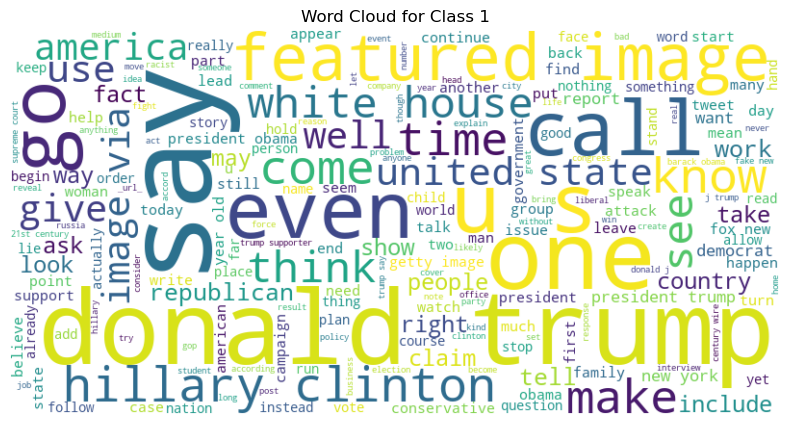

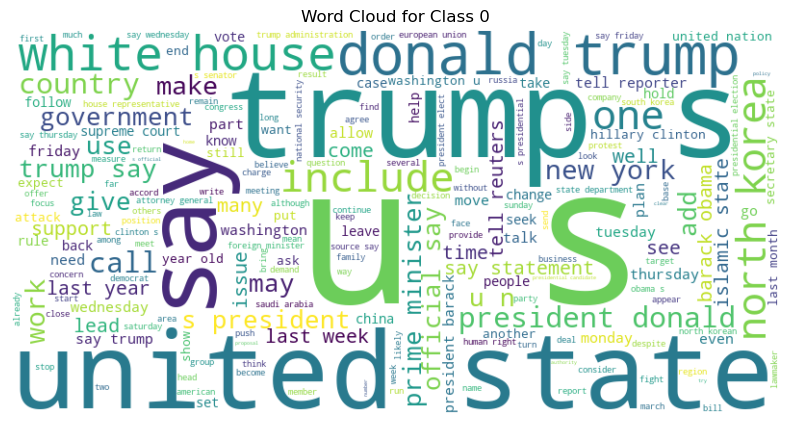

In [57]:
def plot_wordclouds_by_class(df, text_column, label_column, width=800, height=400, bg_color='white'):
    """
    Generates and displays a word cloud for each class in the DataFrame.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing your data.
    text_column : str
        The name of the column that contains the text to analyze.
    label_column : str
        The name of the column containing the class labels.
    width : int, optional
        The width of the generated word cloud image (default is 800).
    height : int, optional
        The height of the generated word cloud image (default is 400).
    bg_color : str, optional
        The background color for the word cloud (default is 'white').
    """
    # Get the unique class labels
    classes = df[label_column].unique()
    
    for cls in classes:
        # Combine text for the current class
        class_text = " ".join(df[df[label_column] == cls][text_column].dropna())
        
        # Generate the word cloud
        wordcloud = WordCloud(width=width, height=height, background_color=bg_color).generate(class_text)
        
        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Word Cloud for Class {cls}")
        plt.show()

# Example usage:
# Assuming your DataFrame is named 'df' and the relevant columns are 'content' for text and 'label' for class:
plot_wordclouds_by_class(df, text_column='content', label_column='label')

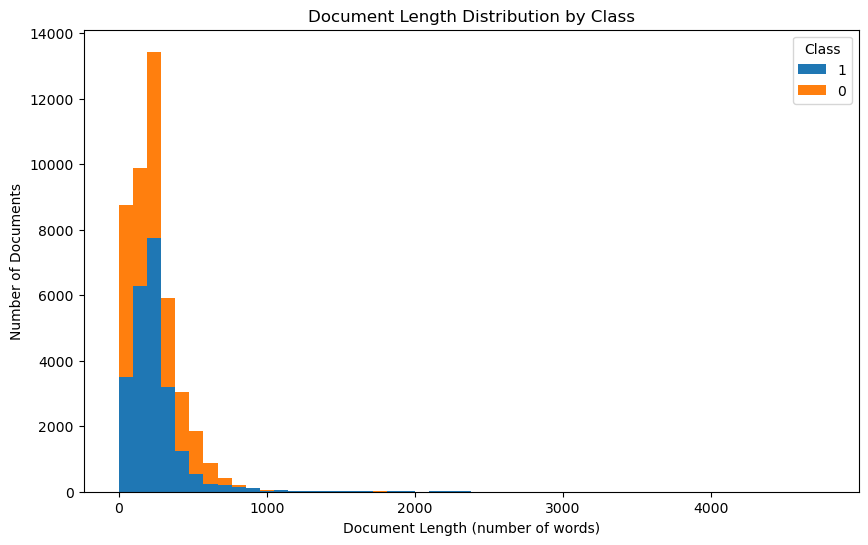

In [35]:
#See document length distribution by class
df['doc_length'] = df['content'].apply(lambda x: len(x.split()))
classes = df['label'].unique(
lengths_by_class = [df[df['label'] == cls]['doc_length'] for cls in classes]

# Plot a stacked histogram of document lengths by class
plt.figure(figsize=(10, 6))
plt.hist(lengths_by_class, bins=50, stacked=True, label=classes)
plt.xlabel('Document Length (number of words)')
plt.ylabel('Number of Documents')
plt.title('Document Length Distribution by Class')
plt.legend(title='Class')
plt.show()

## Phase 2: Misinformation Typology Classification
For the second stage, a new dataset was created (see data scraping notebook) to classify misinformation into one
of four categories from the Molina taxonomy. 400 articles per label were collected, resulting in a balanced dataset of 1,600 samples.

We will apply the exact same cleaning steps as before to this new dataset.

In [63]:
df2 = pd.read_csv('master.csv')
#shuffle the dataset
df2 = df2.sample(frac=1, random_state=999).reset_index(drop=True)
#combine the title and text columns into a single column
df2['content'] = df2['title'].fillna('') + " " + df2['text'].fillna('')
#drop unnecessary columns
df2 = df2[['content', 'class']] 
#basic checks
print("DataFrame Info:")
df2.info()
print("\nClass overview:")
print(df2['class'].value_counts())
#encode the classes
le = LabelEncoder()
df2['label'] = le.fit_transform(df2['class'])
#see the mapping
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", mapping)
#drop unnecessary columns
df2 = df2[['content', 'label']] 
#store
df2.to_csv('Master_FirstClean.csv', index=False)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1600 non-null   object
 1   class    1600 non-null   object
dtypes: object(2)
memory usage: 25.1+ KB

Class overview:
Satire        400
Polarised     400
fabricated    400
Commentary    400
Name: class, dtype: int64
Label mapping: {'Commentary': 0, 'Polarised': 1, 'Satire': 2, 'fabricated': 3}


In [64]:
start_time = time.time()
df2['content'] = df2['content'].progress_apply(basic_clean)
print("Basic clean: {:.4f} seconds".format(time.time() - start_time))
df2.head(3)

  0%|          | 0/1600 [00:00<?, ?it/s]

Basic clean: 10.5346 seconds


,content,label
0,"Perdue Announces Initiative To Even The Playing Field By Giving Chickens Guns SALISBURY, MD--Emphasizing that it was an integral part of the company's mission to raise humanely sourced meat, poultry processing giant Perdue Farms announced a new initiative Tuesday to even the playing field by giving guns to chickens. ""At Perdue, we always strive to ensure animals are treated with dignity and respect, and today we expand upon that commitment by handing each bird a loaded pistol and allowing them a fair chance to escape,"" said Perdue spokesperson Jamie Walton, describing a new policy under which each chicken would be issued a weapon with a single round in the chamber and given an opportunity to kill their captor with a well-placed bullet before they could be taken to slaughter. ""They should get one clean shot. That's just good sportsmanship. So from now on, every chicken in our Perdue facilities will have free and easy access to firearms. We may lose some staff to gunshot wounds, but everyone involved--human or fowl--will have an opportunity to defend themselves. It's only right."" At press time, sources confirmed a shift in the balance of power at several Perdue processing plants had resulted in thousands of employees being slaughter with assembly-line efficiency.",2
1,"Met Police just BLOCKED a pro-Palestine protest from marching outside the BBC Today the Palestine Coalition have been informed by the Met Police that they intend to go back on a previous agreement and impose conditions to prevent us marching from BBC HQ at Portland Place on Saturday 18 January. We have already announced our intention to assemble outside the BBC to protest against the pro-Israel bias of its coverage - something recently highlighted in a detailed report by journalist Owen Jones to which the Corporation has so far not responded. We utterly condemn this attempt to use repressive powers to prevent our planned protest at the BBC. The route for the march was confirmed with the police nearly two months ago and, as agreed with them, was publicly announced on 30 November. This route, beginning at the BBC, has only been used twice in the last 15 months of demonstrations and not since February 2024. With just over a week to go, the Metropolitan Police has now reneged on our agreement and stated its intention to prevent our protest from going ahead as planned. The BBC is a major institution - it is a publicly-funded state broadcaster and is rightly accountable to the public. It is unacceptable for the police to misuse public order powers to shield the BBC from democratic scrutiny. The excuse offered by the police is that our march could cause disruption to a nearby synagogue. It follows representations from pro-Israel groups and activists who have been publicly calling for action to be taken to curtail our right to protest against Israel's ongoing genocide. This includes the Chief Rabbi, Ephraim Mirvis who has openly celebrated the horrific and criminal actions of the Israeli military in Gaza, describing them as the ""most outstanding possible thing that a decent responsible country can do"". In fact, the closest synagogue to the BBC is not even on the route of the march. Moreover, as the Met Police have acknowledged, there has not been a single incident of any threat to a synagogue attached to any of the marches. Any suggestion that our marches are somehow hostile to Jewish people ignores the fact that every march has been joined by thousands of Jewish people - many in an organised Jewish bloc - and addressed by Jewish speakers on the demonstration platforms. Representatives of the Jewish bloc have written to the police seeking a meeting to express their concerns that the police are choosing to listen solely to pro-Israel Jewish voices, but they have not had any response. We firmly reject any attempt to suppress our right to campaign for an end to Israel's genocidal violence and decades long violations of the rights of the Palestinian pe

In [65]:
#apply POS tagging and lemmatiser to entire df
start_time = time.time()
df2['content'] = df2['content'].progress_apply(lemmatize_passage)
print("WordNet Lemmatizer with POS tagging time: {:.4f} seconds".format(time.time() - start_time))
df2.head()

  0%|          | 0/1600 [00:00<?, ?it/s]

WordNet Lemmatizer with POS tagging time: 125.5258 seconds


,content,label
0,"Perdue Announces Initiative To Even The Playing Field By Giving Chickens Guns SALISBURY , MD -- Emphasizing that it be an integral part of the company 's mission to raise humanely sourced meat , poultry processing giant Perdue Farms announce a new initiative Tuesday to even the playing field by give gun to chicken . `` At Perdue , we always strive to ensure animal be treat with dignity and respect , and today we expand upon that commitment by hand each bird a loaded pistol and allow them a fair chance to escape , '' say Perdue spokesperson Jamie Walton , describe a new policy under which each chicken would be issue a weapon with a single round in the chamber and give an opportunity to kill their captor with a well-placed bullet before they could be take to slaughter . `` They should get one clean shot . That 's just good sportsmanship . So from now on , every chicken in our Perdue facility will have free and easy access to firearm . We may lose some staff to gunshot wound , but everyone involve -- human or fowl -- will have an opportunity to defend themselves . It 's only right . '' At press time , source confirm a shift in the balance of power at several Perdue processing plant have result in thousand of employee be slaughter with assembly-line efficiency .",2
1,"Met Police just BLOCKED a pro-Palestine protest from march outside the BBC Today the Palestine Coalition have be inform by the Met Police that they intend to go back on a previous agreement and impose condition to prevent u march from BBC HQ at Portland Place on Saturday 18 January . We have already announce our intention to assemble outside the BBC to protest against the pro-Israel bias of it coverage - something recently highlight in a detailed report by journalist Owen Jones to which the Corporation have so far not responded . We utterly condemn this attempt to use repressive power to prevent our planned protest at the BBC . The route for the march be confirm with the police nearly two month ago and , a agree with them , be publicly announce on 30 November . This route , begin at the BBC , have only be use twice in the last 15 month of demonstration and not since February 2024 . With just over a week to go , the Metropolitan Police have now renege on our agreement and state it intention to prevent our protest from go ahead a plan . The BBC be a major institution - it be a publicly-funded state broadcaster and be rightly accountable to the public . It be unacceptable for the police to misuse public order power to shield the BBC from democratic scrutiny . The excuse offer by the police be that our march could cause disruption to a nearby synagogue . It follow representation from pro-Israel group and activist who have be publicly call for action to be take to curtail our right to protest against Israel 's ongoing genocide . This include the Chief Rabbi , Ephraim Mirvis who have openly celebrate the horrific and criminal action of the Israeli military in Gaza , describe them a the `` most outstanding possible thing that a decent responsible country can do '' . In fact , the close synagogue to the BBC be not even on the route of the march . Moreover , a the Met Police have acknowledge , there have not be a single incident of any threat to a synagogue attach to any of the march . Any suggestion that our march be somehow hostile to Jewish people ignore the fact that every march have be join by thousand of Jewish people - many in an organised Jewish bloc - and address by Jewish speaker on the demonstration platform . Representatives of the Jewish bloc have write to the police seek a meeting to express their concern that the police be choose to listen solely to pro-Israel Jewish voice , but they have not have any response . We firmly reject any attempt to suppress our right to campaign for an end to Israel 's genocidal violence and decade long violation of the right of the Palestinian people . In the past few week , Israel have intensify it indiscriminate

In [66]:
# Apply final cleaning
start_time = time.time()
df2['content'] = df2['content'].apply(remove_stopwords_and_punct)
print("Removing stopwords and punctuation: {:.4f} seconds".format(time.time() - start_time))
df2.head(3)

Removing stopwords and punctuation: 14.6390 seconds


,content,label
0,perdue announces initiative even playing field giving chickens guns salisbury md -- emphasizing integral part company 's mission raise humanely sourced meat poultry processing giant perdue farms announce new initiative tuesday even playing field give gun chicken `` perdue always strive ensure animal treat dignity respect today expand upon commitment hand bird loaded pistol allow fair chance escape `` say perdue spokesperson jamie walton describe new policy chicken would issue weapon single round chamber give opportunity kill captor well-placed bullet could take slaughter `` get one clean shot 's good sportsmanship every chicken perdue facility free easy access firearm may lose staff gunshot wound everyone involve -- human fowl -- opportunity defend 's right `` press time source confirm shift balance power several perdue processing plant result thousand employee slaughter assembly-line efficiency,2
1,met police blocked pro-palestine protest march outside bbc today palestine coalition inform met police intend go back previous agreement impose condition prevent u march bbc hq portland place saturday 18 january already announce intention assemble outside bbc protest pro-israel bias coverage something recently highlight detailed report journalist owen jones corporation far responded utterly condemn attempt use repressive power prevent planned protest bbc route march confirm police nearly two month ago agree publicly announce 30 november route begin bbc use twice last 15 month demonstration since february 2024 week go metropolitan police renege agreement state intention prevent protest go ahead plan bbc major institution publicly-funded state broadcaster rightly accountable public unacceptable police misuse public order power shield bbc democratic scrutiny excuse offer police march could cause disruption nearby synagogue follow representation pro-israel group activist publicly call action take curtail right protest israel 's ongoing genocide include chief rabbi ephraim mirvis openly celebrate horrific criminal action israeli military gaza describe `` outstanding possible thing decent responsible country `` fact close synagogue bbc even route march moreover met police acknowledge single incident threat synagogue attach march suggestion march somehow hostile jewish people ignore fact every march join thousand jewish people many organised jewish bloc address jewish speaker demonstration platform representatives jewish bloc write police seek meeting express concern police choose listen solely pro-israel jewish voice response firmly reject attempt suppress right campaign end israel 's genocidal violence decade long violation right palestinian people past week israel intensify indiscriminate attack include hospital civilian shelter so-called 'humanitarian safe zone ongoing complicity british government crime continue bring people onto street huge number march represent diverse cross section public include palestinian community many relative kill israel remain dialogue metropolitan police call immediately abandon intention prevent protest bbc call rightly outrage israel 's ongoing genocide uphold democratic right protest join u march london saturday 18 january national march palestine coalition,1
2,'s moment mark zuckerberg give away game like rest tech billionaire class meta ceo mark zuckerberg decide give pretense ethic order cozy president-elect donald trump zuckerbergkilledmeta 's fact check andendedall company 's diversity equity inclusion program order damage control -- audition trump administration 's favor -- zuckerberg go joe rogan 's podcast become forum billionaire act aggrieve theytake control country rogan ask zuckerberg elaborate become victim politicized government zuckerberg ramble `` organization look u like really involve social medium like think like cfpb like financial -- n't even know stand 's ... 's financial organization elizabeth warren set 's basically 's like 're bank `` say consumer financial pro

In [67]:
df2.to_csv('final_clean_phase2.csv', index=False)

### Data Exploration

In [69]:
#get top 10 words for each class
top_words = get_top_n_words_by_class(df2, 'content', 'label', n=10)
for label, words in top_words.items():
    print(f"Top words for class {label}:")
    print(words)
    print()

Top words for class 2:
[('say', 487), ('one', 406), ('people', 311), ('time', 309), ('like', 303), ('get', 285), ('trump', 263), ('year', 233), ('make', 230), ('would', 225)]

Top words for class 1:
[('trump', 1507), ('say', 1105), ('people', 921), ('year', 728), ('one', 717), ('make', 634), ('government', 632), ('would', 614), ('also', 579), ('president', 511)]

Top words for class 3:
[('says', 92), ('claim', 52), ('obama', 46), ('health', 37), ('say', 37), ('state', 33), ('narrative', 33), ('president', 32), ('government', 32), ('one', 31)]

Top words for class 0:
[('trump', 1962), ('one', 1114), ('people', 1101), ('would', 1059), ('year', 1002), ('say', 958), ('make', 946), ('government', 826), ('president', 751), ('time', 717)]



In [70]:
#Get top 10 bigrams for each class
top_ngrams = get_top_n_ngrams_by_class(df, 'content', 'label', ngram_range=(2,2), n=10)
for label, ngrams in top_ngrams.items():
    print(f"Top bi-grams for class {label}:")
    print(ngrams)

Top bi-grams for class 1:
[('donald trump', 17026), ('featured image', 7606), ('hillary clinton', 7595), ('white house', 7037), ('united states', 6649), ('image via', 6329), ('president trump', 4412), ('new york', 4382), ('president obama', 4218), ('getty images', 3981)]
Top bi-grams for class 0:
[('united states', 12210), ('donald trump', 10206), ('white house', 9200), ('north korea', 6327), ('president donald', 5921), ('new york', 4829), ('prime minister', 4233), ('trump say', 4090), ('official say', 4076), ('say statement', 3994)]


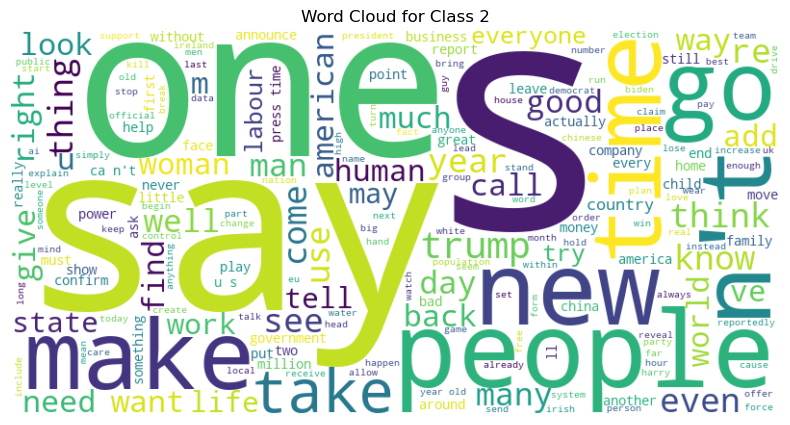

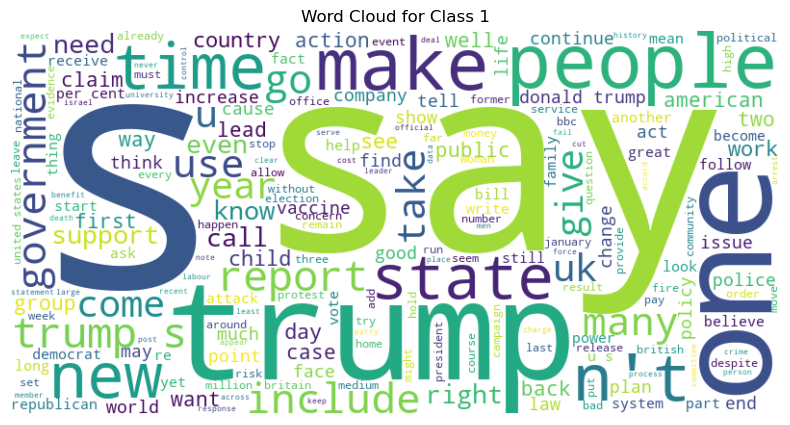

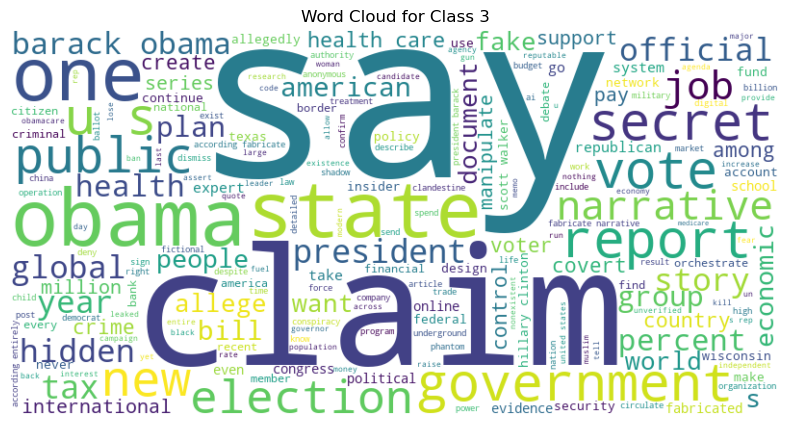

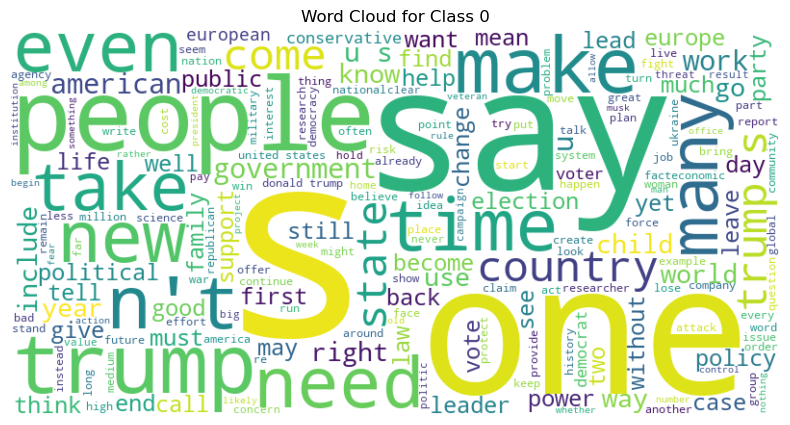

In [71]:
#print wordcloud for each class
plot_wordclouds_by_class(df2, text_column='content', label_column='label')

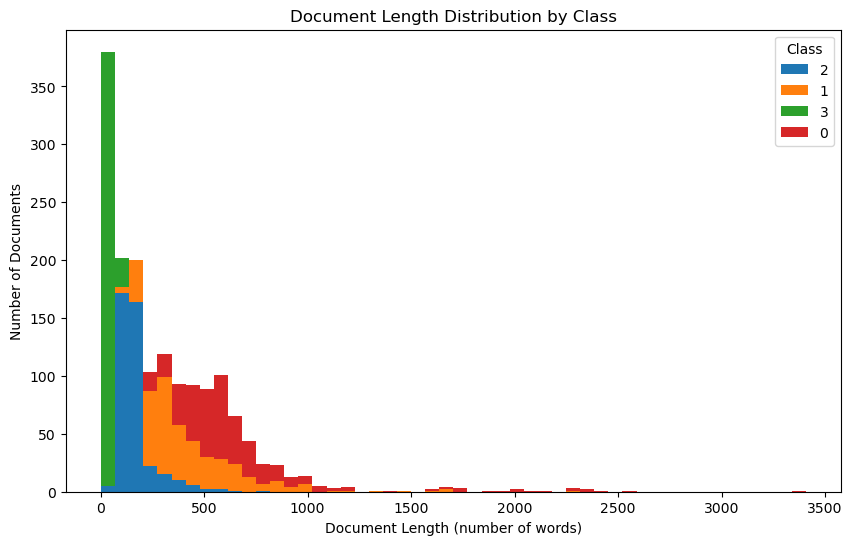

In [72]:
#See document length distribution by class
df2['doc_length'] = df2['content'].apply(lambda x: len(x.split()))
classes = df2['label'].unique()
lengths_by_class = [df2[df2['label'] == cls]['doc_length'] for cls in classes]

# Plot a stacked histogram of document lengths by class
plt.figure(figsize=(10, 6))
plt.hist(lengths_by_class, bins=50, stacked=True, label=classes)
plt.xlabel('Document Length (number of words)')
plt.ylabel('Number of Documents')
plt.title('Document Length Distribution by Class')
plt.legend(title='Class')
plt.show()

## Extra dataset to validate
Extra data from https://www.kaggle.com/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k

In [20]:
fake_df = pd.read_csv('DataSet_Misinfo_FAKE.csv')
fake_df = fake_df.sample(n=250, random_state=123).copy()
fake_df.drop(columns=['Unnamed: 0'], inplace=True)
fake_df['label'] = 1
true_df = pd.read_csv('DataSet_Misinfo_TRUE.csv')
true_df = fake_df.sample(n=250, random_state=123).copy()
true_df['label'] = 0
#combine the dataframes
data = pd.concat([true_df, fake_df], ignore_index=True)
#shuffle the dataset
data = data.sample(frac=1, random_state=999).reset_index(drop=True)
#rename column
data = data.rename(columns={"text": "content"})
#store
data.to_csv('ExtraDataset.csv', index=False)
data.head()

content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [21]:
start_time = time.time()
#replace the censored words
data['content'] = data['content'].progress_apply(lambda x: replace_censored_words(x, substitutions))
#take care of the other random asterixes by replacing with a space e.g. "language***killer" and "2016*you"
data['content'] = data['content'].str.replace(r'\*', ' ', regex=True)
#remove twitter noise (any time twitter is repeated 3 or more times in a row)
data['content'] = data['content'].str.replace(r'(?i)(?:twitter){3,}', ' ', regex=True)
#print time taken
print("Replace censored words: {:.4f} seconds".format(time.time() - start_time))
#quick check
data.head(3)

  0%|          | 0/500 [00:00<?, ?it/s]

Replace censored words: 0.6005 seconds


,content,label
0,"American troops stationed in the Baltic States tore Lithuanian flag away from the State Prosecutor's building in Kaunas, and shredded it into pieces. The incident occurred in April 2018, but was kept away from the public.\r\n\r\n&nbullshitp;",0
1,"It was announced last week that George Soros was donating over $25 MILLION to Hillary s campaign. Today we find out that George Soros is making decisions for Hillary that could affect our national security and the security of other nations worldwide.More leaked e-mails from Hillary Clinton during her time as Secretary of State now prove that she was taking foreign policy advice from radical leftist billionaire George Soros.WikiLeaks latest email leak shows how Soros had a direct line to Secretary of State Hillary Clinton when it came to foreign policy decisions she was tasked to act upon.How can we ever trust Hillary to make important decisions that affect the national security of our nation and of foreign nations now that it has been proven she is relying on advice from major donors like the unhinged radical, George Soros?Here is the content of the email. (A screen shot of the actual email can be found below): Dear Hillary, A serious situation has arisen in Albania which needs urgent attention at senior levels of the US government. You may know that an opposition demonstration in Tirana on Friday resulted in the deaths of three people and the destruction of property. There are serious concerns about further unrest connected to a counter-demonstration to be organized by the governing party on Wednesday and a follow-up event by the opposition two days later to memorialize the victims. The prospect of tens of thousands of people entering the streets in an already inflamed political environment bodes ill for the return of public order and the country s fragile democratic process.",1
2,"Enough is enough. Americans need to start making business owners and their employees pay up for discriminating against them simply because they dare to show their support for our President. Good for this Trump supporter for fighting back against the intolerant left. A lot of Americans would be happy to contribute to his legal defense Bartenders at a West Village hot spot served up discrimination with a liberal twist refusing to serve a customer because he was wearing a Make America Great Again hat, according to a lawsuit.Greg Piatek, 30, an accountant from Philadelphia, claims he was snubbed and eventually 86 d by workers at The Happiest Hour on West 10th Street over his conservative fashion statement, popularized by Donald Trump on the campaign trail, he told The Post. Anyone who supports Trump or believes what you believe is not welcome here! And you need to leave right now because we won t serve you! Piatek claims he was told as he was shown the door by a manager.The shake-up started when Piatek and two pals, after a visit to the 9/11 Memorial, ordered drinks at the posh tavern around 6:30 p.m. on Jan. 28.A female bartender served Piatek a $15 jalape o margarita and his pals beers. But when he tried to order a second round, a male bartender noticed his hat and skipped them, he said.One of Piatek s pals pointed out it was their turn to be served, but the bartender scoffed. Is that hat a joke? the Manhattan Supreme Court suit claims. Ignoring me because I m wearing the hat is ridiculous, Piatek said. It s really sad. The flustered bartender got them a second round but allegedly slammed the drinks down. A third bartender also asked Piatek if his lid was a joke and shouted, I can t believe you would support someone so terrible and you must be as terrible a person! Piatek claimed. I wasn t even trying to order a drink and she said, Don t even try to order from me. I won t get you a drink, Piatek alleged.A manager said he spoke to the bar owner, and was told, Anyone who supports Trump or believes what you believe is not welcome here. And you need to leave right now because we won t serve yo

In [22]:
start_time = time.time()
data['content'] = data['content'].progress_apply(basic_clean)
print("Basic clean: {:.4f} seconds".format(time.time() - start_time))
data.head(3)

  0%|          | 0/500 [00:00<?, ?it/s]

Basic clean: 2.1504 seconds


,content,label
0,"American troops stationed in the Baltic States tore Lithuanian flag away from the State Prosecutor's building in Kaunas, and shredded it into pieces. The incident occurred in April 2018, but was kept away from the public.\n&nbullshitp;",0
1,"It was announced last week that George Soros was donating over _CUR_25 MILLION to Hillary s campaign. Today we find out that George Soros is making decisions for Hillary that could affect our national security and the security of other nations worldwide.More leaked e-mails from Hillary Clinton during her time as Secretary of State now prove that she was taking foreign policy advice from radical leftist billionaire George Soros.WikiLeaks latest email leak shows how Soros had a direct line to Secretary of State Hillary Clinton when it came to foreign policy decisions she was tasked to act upon.How can we ever trust Hillary to make important decisions that affect the national security of our nation and of foreign nations now that it has been proven she is relying on advice from major donors like the unhinged radical, George Soros?Here is the content of the email. : Dear Hillary, A serious situation has arisen in Albania which needs urgent attention at senior levels of the US government. You may know that an opposition demonstration in Tirana on Friday resulted in the deaths of three people and the destruction of property. There are serious concerns about further unrest connected to a counter-demonstration to be organized by the governing party on Wednesday and a follow-up event by the opposition two days later to memorialize the victims. The prospect of tens of thousands of people entering the streets in an already inflamed political environment bodes ill for the return of public order and the country s fragile democratic process.",1
2,"Enough is enough. Americans need to start making business owners and their employees pay up for discriminating against them simply because they dare to show their support for our President. Good for this Trump supporter for fighting back against the intolerant left. A lot of Americans would be happy to contribute to his legal defense Bartenders at a West Village hot spot served up discrimination with a liberal twist refusing to serve a customer because he was wearing a Make America Great Again hat, according to a lawsuit.Greg Piatek, 30, an accountant from Philadelphia, claims he was snubbed and eventually 86 d by workers at The Happiest Hour on West 10th Street over his conservative fashion statement, popularized by Donald Trump on the campaign trail, he told The Post. Anyone who supports Trump or believes what you believe is not welcome here! And you need to leave right now because we won t serve you! Piatek claims he was told as he was shown the door by a manager.The shake-up started when Piatek and two pals, after a visit to the 9/11 Memorial, ordered drinks at the posh tavern around 6:30 p.m. on Jan. 28.A female bartender served Piatek a _CUR_15 jalape o margarita and his pals beers. But when he tried to order a second round, a male bartender noticed his hat and skipped them, he said.One of Piatek s pals pointed out it was their turn to be served, but the bartender scoffed. Is that hat a joke? the Manhattan Supreme Court suit claims. Ignoring me because I m wearing the hat is ridiculous, Piatek said. It s really sad. The flustered bartender got them a second round but allegedly slammed the drinks down. A third bartender also asked Piatek if his lid was a joke and shouted, I can t believe you would support someone so terrible and you must be as terrible a person! Piatek claimed. I wasn t even trying to order a drink and she said, Don t even try to order from me. I won t get you a drink, Piatek alleged.A manager said he spoke to the bar owner, and was told, Anyone who supports Trump or believes what you believe is not welcome here. And you need to leave right now because we won t serve you! according to the suit. For entire story: New York

In [23]:
#apply POS tagging and lemmatiser to entire df
start_time = time.time()
data['content'] = data['content'].progress_apply(lemmatize_passage)
print("WordNet Lemmatizer with POS tagging time: {:.4f} seconds".format(time.time() - start_time))
data.head(3)

  0%|          | 0/500 [00:00<?, ?it/s]

WordNet Lemmatizer with POS tagging time: 31.8947 seconds


,content,label
0,"American troop station in the Baltic States tore Lithuanian flag away from the State Prosecutor 's building in Kaunas , and shred it into piece . The incident occur in April 2018 , but be keep away from the public . & nbullshitp ;",0
1,"It be announce last week that George Soros be donate over _CUR_25 MILLION to Hillary s campaign . Today we find out that George Soros be make decision for Hillary that could affect our national security and the security of other nation worldwide.More leaked e-mail from Hillary Clinton during her time a Secretary of State now prove that she be take foreign policy advice from radical leftist billionaire George Soros.WikiLeaks late email leak show how Soros have a direct line to Secretary of State Hillary Clinton when it come to foreign policy decision she be task to act upon.How can we ever trust Hillary to make important decision that affect the national security of our nation and of foreign nation now that it have be prove she be rely on advice from major donor like the unhinged radical , George Soros ? Here be the content of the email . : Dear Hillary , A serious situation have arise in Albania which need urgent attention at senior level of the US government . You may know that an opposition demonstration in Tirana on Friday result in the death of three people and the destruction of property . There be serious concern about further unrest connect to a counter-demonstration to be organize by the govern party on Wednesday and a follow-up event by the opposition two day later to memorialize the victim . The prospect of ten of thousand of people enter the street in an already inflamed political environment bodes ill for the return of public order and the country s fragile democratic process .",1
2,"Enough be enough . Americans need to start make business owner and their employee pay up for discriminate against them simply because they dare to show their support for our President . Good for this Trump supporter for fight back against the intolerant left . A lot of Americans would be happy to contribute to his legal defense Bartenders at a West Village hot spot serve up discrimination with a liberal twist refuse to serve a customer because he be wear a Make America Great Again hat , accord to a lawsuit.Greg Piatek , 30 , an accountant from Philadelphia , claim he be snub and eventually 86 d by worker at The Happiest Hour on West 10th Street over his conservative fashion statement , popularize by Donald Trump on the campaign trail , he tell The Post . Anyone who support Trump or believe what you believe be not welcome here ! And you need to leave right now because we win t serve you ! Piatek claim he be tell a he be show the door by a manager.The shake-up start when Piatek and two pal , after a visit to the 9/11 Memorial , order drink at the posh tavern around 6:30 p.m. on Jan. 28.A female bartender serve Piatek a _CUR_15 jalape o margarita and his pal beer . But when he try to order a second round , a male bartender notice his hat and skip them , he said.One of Piatek s pal point out it be their turn to be serve , but the bartender scoffed . Is that hat a joke ? the Manhattan Supreme Court suit claim . Ignoring me because I m wear the hat be ridiculous , Piatek say . It s really sad . The flustered bartender get them a second round but allegedly slam the drink down . A third bartender also ask Piatek if his lid be a joke and shout , I can t believe you would support someone so terrible and you must be a terrible a person ! Piatek claim . I wasn t even try to order a drink and she say , Don t even try to order from me . I win t get you a drink , Piatek alleged.A manager say he speak to the bar owner , and be tell , Anyone who support Trump or believe what you believe be not welcome here . And you need to leave right now because we win t serve you ! accord to the suit . For entire story : New York Post New York Post reporter Dean Balsamini have a similar experience when he wear a Tru

In [24]:
# Apply final cleaning
start_time = time.time()
data['content'] = data['content'].apply(remove_stopwords_and_punct)
print("Removing stopwords and punctuation: {:.4f} seconds".format(time.time() - start_time))
data.head(3)

Removing stopwords and punctuation: 2.8240 seconds


,content,label
0,american troop station baltic states tore lithuanian flag away state prosecutor 's building kaunas shred piece incident occur april 2018 keep away public nbullshitp,0
1,announce last week george soros donate _cur_25 million hillary campaign today find george soros make decision hillary could affect national security security nation worldwide.more leaked e-mail hillary clinton time secretary state prove take foreign policy advice radical leftist billionaire george soros.wikileaks late email leak show soros direct line secretary state hillary clinton come foreign policy decision task act upon.how ever trust hillary make important decision affect national security nation foreign nation prove rely advice major donor like unhinged radical george soros content email dear hillary serious situation arise albania need urgent attention senior level us government may know opposition demonstration tirana friday result death three people destruction property serious concern unrest connect counter-demonstration organize govern party wednesday follow-up event opposition two day later memorialize victim prospect ten thousand people enter street already inflamed political environment bodes ill return public order country fragile democratic process,1
2,enough enough americans need start make business owner employee pay discriminate simply dare show support president good trump supporter fight back intolerant left lot americans would happy contribute legal defense bartenders west village hot spot serve discrimination liberal twist refuse serve customer wear make america great hat accord lawsuit.greg piatek 30 accountant philadelphia claim snub eventually 86 worker happiest hour west 10th street conservative fashion statement popularize donald trump campaign trail tell post anyone support trump believe believe welcome need leave right win serve piatek claim tell show door manager.the shake-up start piatek two pal visit 9/11 memorial order drink posh tavern around 6:30 p.m. jan. 28.a female bartender serve piatek _cur_15 jalape margarita pal beer try order second round male bartender notice hat skip said.one piatek pal point turn serve bartender scoffed hat joke manhattan supreme court suit claim ignoring wear hat ridiculous piatek say really sad flustered bartender get second round allegedly slam drink third bartender also ask piatek lid joke shout believe would support someone terrible must terrible person piatek claim even try order drink say even try order win get drink piatek alleged.a manager say speak bar owner tell anyone support trump believe believe welcome need leave right win serve accord suit entire story new york post new york post reporter dean balsamini similar experience wear trump hat around nyc recount day scorn discrimination make america great hat visit hot spot city may well wear red sox hat yankee stadium.the mere sight cap nearly cause riot historic stonewall inn christopher street site 1969 riot launch gay right movement come gay bar gay bar hat one woman lecture large crowd gathered.at soho sceney la esquina celebullshit like julia roberts nosh _cur_26 enchilada server nearly lose lunch show oh god see serious kid one waiter gasped.my companion quickly shunt sight table near back wall talk man instruct street vendor browse along 125th street near apollo theater.hipsters trustafarians along bedford avenue williamsburg either double take shoot death stare snarky remark take stupid f ing hat one skinny-jeans-wearer sneered.at high-end chapeau peddler goorin bros. overhear salesman tell colleague lose sh walk ask hold hat admire fedora grimace surprised nobody knock hat head mother two scold cross path along central park west 63rd street make america great right,1


In [25]:
data.to_csv('ExtraDatasetProcessed.csv', index=False)